# Case study: VAT rates across Europe

The repository has a JSON file that provides a simple to consume JSON document, containing a list of VAT rates per country in the European Union.

There's a <code>last_updated</code> ISO 8601 timestamp in the root that tells when the last VAT change (or bug fix) was made, and there is a <code>disclaimer</code>. The <code>rates</code> object contains all the different rates per country, based on its 2 character country code:

 ```
 countries = {
  "AT": "Austria",
  "BE": "Belgium",
  "BG": "Bulgaria",
  "CY": "Cyprus",
  "CZ": "Czech Republic",
  "DE": "Germany",
  "DK": "Denmark",
  "EE": "Estonia",
  "GR": "Greece", 
  "ES": "Spain",
  "FI": "Finland",
  "FR": "France",
  "HR": "Croatia",
  "HU": "Hungary",
  "IE": "Ireland",
  "IT": "Italy",
  "LT": "Lithuania",
  "LU": "Luxembourg",
  "LV": "Latvia",
  "MT": "Malta",
  "NL": "The Netherlands",
  "PL": "Poland",
  "PT": "Portugal",
  "RO": "Romania",
  "SE": "Sweden",
  "SI": "Slovenia",
  "SK": "Slovakia"
}
 ```
The rate object contains the country name, the local name of the tax in the local language, its abbreviation, and a couple of different tax rates that exist in the country. The values are always numeric (with decimals), or a boolean false if the rate is not used in the country.

- **Standard VAT rate (standard_rate)**: Rate that EU countries have to apply to all non-exempt goods and services.
- **Reduced rates of VAT (reduced_rate)**: EU countries have also the option to apply one or two reduced rates.

# Architectural overview

![Architectureal Overview](resources/images/architecture-overview.png)

# Imports and setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
%matplotlib inline

In [2]:
pysqldf = lambda q: sqldf(q, globals())

In [3]:
file_path = 'resources/data/rates.json'

In [4]:
sns.set_style(style="whitegrid")

# 1. Load the data

In [5]:
df = pd.read_json(file_path)

In [6]:
df.head()

,last_updated,disclaimer,rates
AT,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Austria', 'vat_name': 'Umsatzsteu..."
BE,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Belgium', 'vat_name': 'Taxe sur l..."
BG,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Bulgaria', 'vat_name': 'Dana Doba..."
CY,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Cyprus', 'vat_name': 'Foros prost..."
CZ,2021-05-27T01:20Z,This data is compiled from official European C...,"{'country': 'Czech Republic', 'vat_name': 'Dan..."


In [7]:
df_flattened = pd.concat([df.drop(['last_updated', 'disclaimer', 'rates'], axis=1), \
                          df.rates.apply(pd.Series)], axis=1)
df_flattened.head(5)

,country,vat_name,vat_abbr,standard_rate,reduced_rate,reduced_rate_alt,super_reduced_rate,parking_rate
AT,Austria,Umsatzsteuer,USt,20.0,10,13,False,12
BE,Belgium,Taxe sur la valeur ajoutée,TVA/BTW,21.0,12,6,False,12
BG,Bulgaria,Dana Dobavena Stoynost,DDS,20.0,9,False,False,False
CY,Cyprus,Foros prostithemenis axias,FPA,19.0,9,5,False,False
CZ,Czech Republic,Dani z pridane hotnoty,DPH,21.0,15,10,False,False


Check column types

In [8]:
df_flattened.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, AT to SK
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27 non-null     object 
 1   vat_name            27 non-null     object 
 2   vat_abbr            27 non-null     object 
 3   standard_rate       27 non-null     float64
 4   reduced_rate        27 non-null     object 
 5   reduced_rate_alt    27 non-null     object 
 6   super_reduced_rate  27 non-null     object 
 7   parking_rate        27 non-null     object 
dtypes: float64(1), object(7)
memory usage: 1.9+ KB


Transform numerical columns

In [9]:
num_columns = ['standard_rate', 'reduced_rate', 'reduced_rate_alt', 'super_reduced_rate', 'parking_rate']

In [10]:
(df_flattened[num_columns] == False).sum()

standard_rate          0
reduced_rate           1
reduced_rate_alt       8
super_reduced_rate    23
parking_rate          22
dtype: int64

In [11]:
(df_flattened[num_columns] == 0).sum()

standard_rate          0
reduced_rate           1
reduced_rate_alt       8
super_reduced_rate    23
parking_rate          22
dtype: int64

In [12]:
df_flattened[num_columns] = df_flattened[num_columns].astype(float, errors = 'raise')
df_flattened.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, AT to SK
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27 non-null     object 
 1   vat_name            27 non-null     object 
 2   vat_abbr            27 non-null     object 
 3   standard_rate       27 non-null     float64
 4   reduced_rate        27 non-null     float64
 5   reduced_rate_alt    27 non-null     float64
 6   super_reduced_rate  27 non-null     float64
 7   parking_rate        27 non-null     float64
dtypes: float64(5), object(3)
memory usage: 1.9+ KB


In [13]:
(df_flattened[num_columns] == 0).sum()

standard_rate          0
reduced_rate           1
reduced_rate_alt       8
super_reduced_rate    23
parking_rate          22
dtype: int64

In [14]:
df_flattened

,country,vat_name,vat_abbr,standard_rate,reduced_rate,reduced_rate_alt,super_reduced_rate,parking_rate
AT,Austria,Umsatzsteuer,USt,20.0,10.0,13.0,0.0,12.0
BE,Belgium,Taxe sur la valeur ajoutée,TVA/BTW,21.0,12.0,6.0,0.0,12.0
BG,Bulgaria,Dana Dobavena Stoynost,DDS,20.0,9.0,0.0,0.0,0.0
CY,Cyprus,Foros prostithemenis axias,FPA,19.0,9.0,5.0,0.0,0.0
CZ,Czech Republic,Dani z pridane hotnoty,DPH,21.0,15.0,10.0,0.0,0.0
DE,Germany,Umsatzsteuer,USt,19.0,7.0,0.0,0.0,0.0
DK,Denmark,Omsaetningsavgift,MOMS,25.0,0.0,0.0,0.0,0.0
EE,Estonia,Käibemaks,KMKR,20.0,9.0,0.0,0.0,0.0
ES,Spain,Impuesto sobre el valor añadido,IVA,21.0,10.0,0.0,4.0,0.0
FI,Finland,Arvonlisävero,AVL,24.0,14.0,10.0,0.0,0.0


# 2. Run queries

# Most common standard tax rates across Europe

With value counts

In [15]:
df_flattened['standard_rate'].value_counts()

21.0    6
20.0    5
23.0    3
25.0    3
19.0    3
22.0    2
24.0    2
18.0    1
17.0    1
27.0    1
Name: standard_rate, dtype: int64

Graphically

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Standard Rate')]

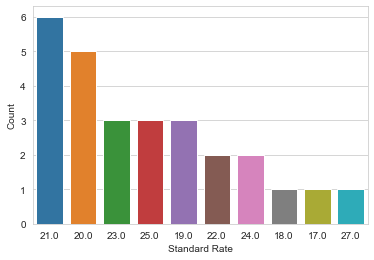

In [16]:
stvat = sns.countplot(x='standard_rate', \
                      data=df_flattened, \
                      order = df_flattened['standard_rate'].value_counts().index)
stvat.set(xlabel='Standard Rate', ylabel='Count')

Get countries with most common standard tax rates (21.0 and 20.0)

In [17]:
most_common = df_flattened['standard_rate'].value_counts().index.tolist()[:2]
df_flattened[df_flattened['standard_rate'].isin(most_common)][['country', 'standard_rate']] \
    .sort_values(by=['standard_rate'])

,country,standard_rate
AT,Austria,20.0
BG,Bulgaria,20.0
EE,Estonia,20.0
FR,France,20.0
SK,Slovakia,20.0
BE,Belgium,21.0
CZ,Czech Republic,21.0
ES,Spain,21.0
LT,Lithuania,21.0
LV,Latvia,21.0


# Countries which are more than 20% above the average of standard VAT rate

With the DataFrame

In [18]:
avg = df_flattened['standard_rate'].mean()
above = avg * 1.2
print('Average: {}'.format(avg))
print('20% above average: {}'.format(above))
df_flattened[df_flattened['standard_rate'] > above]

Average: 21.51851851851852
20% above average: 25.822222222222223


,country,vat_name,vat_abbr,standard_rate,reduced_rate,reduced_rate_alt,super_reduced_rate,parking_rate
HU,Hungary,Általános forgalmi adó,AFA,27.0,18.0,5.0,0.0,0.0


Graphically

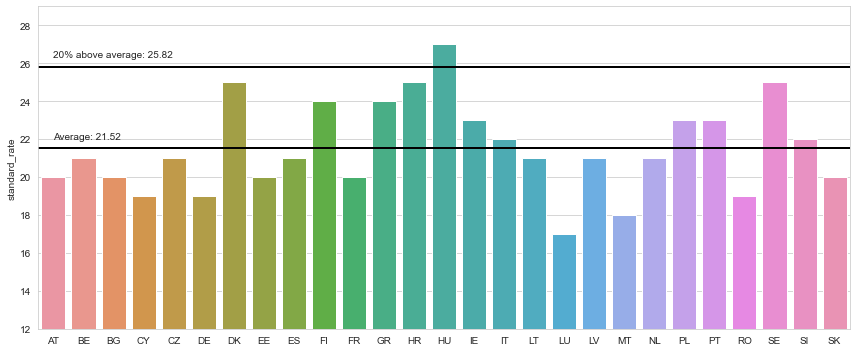

In [19]:
plt.figure(figsize=(12,5)) # this creates a figure 12 inch wide, 5 inch high
sns.barplot(x=df_flattened.index, y='standard_rate', data=df_flattened)
plt.ylim(df_flattened['standard_rate'].min() - 5, df_flattened['standard_rate'].max() + 2)

# Draw reference lines
plt.axhline(y=avg, linewidth=2, color='black')
plt.axhline(y=above, linewidth=2, color='black')

# Add text to reference lines
offset = 0.5
plt.text(0, avg+offset, 'Average: {:.2f}'.format(avg))
plt.text(0, above+offset, '20% above average: {:.2f}'.format(above))

# Display plot
plt.tight_layout()
plt.show()

# Countries where the range between reduced and standard rate is not overlapping

Remove records that don't have the reduced_rate value

In [20]:
df_reduced = df_flattened[df_flattened['reduced_rate'] != 0][['country', 'reduced_rate', 'standard_rate']]
len(df_reduced)

26

In [21]:
df_reduced

,country,reduced_rate,standard_rate
AT,Austria,10.0,20.0
BE,Belgium,12.0,21.0
BG,Bulgaria,9.0,20.0
CY,Cyprus,9.0,19.0
CZ,Czech Republic,15.0,21.0
DE,Germany,7.0,19.0
EE,Estonia,9.0,20.0
ES,Spain,10.0,21.0
FI,Finland,14.0,24.0
FR,France,10.0,20.0


Create a DataFrame with overlapping information between countries

In [22]:
overlaps = pysqldf("SELECT a.country country_A, a.reduced_rate red_A, a.standard_rate std_A, \
                             b.country country_B, b.reduced_rate red_B, b.standard_rate std_B \
                      FROM df_reduced a  \
                      INNER JOIN df_reduced b \
                        ON a.country <> b.country \
                        AND (a.reduced_rate BETWEEN b.reduced_rate AND b.standard_rate \
                                OR a.standard_rate BETWEEN b.reduced_rate AND b.standard_rate);")
overlaps.head(10)

,country_A,red_A,std_A,country_B,red_B,std_B
0,Austria,10.0,20.0,Belgium,12.0,21.0
1,Austria,10.0,20.0,Bulgaria,9.0,20.0
2,Austria,10.0,20.0,Cyprus,9.0,19.0
3,Austria,10.0,20.0,Czech Republic,15.0,21.0
4,Austria,10.0,20.0,Germany,7.0,19.0
5,Austria,10.0,20.0,Estonia,9.0,20.0
6,Austria,10.0,20.0,Spain,10.0,21.0
7,Austria,10.0,20.0,Finland,14.0,24.0
8,Austria,10.0,20.0,France,10.0,20.0
9,Austria,10.0,20.0,Greece,13.0,24.0


Get countries that don't belong to the previous DataFrame

In [23]:
pysqldf("SELECT * FROM df_reduced \
           WHERE country NOT IN (SELECT country_A FROM overlaps) \
            AND country NOT IN (SELECT country_B FROM overlaps) \
           ORDER BY country").head()

,country,reduced_rate,standard_rate
